In [12]:
%matplotlib inline

import sys, os
sys.path.append("../../..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.dates import DayLocator, HourLocator, DateFormatter



# Averaging

In [13]:
Data = pd.read_csv('../../Terrain/Tide/051800_20180611_1439_tide_deva/051800_20180611_1439_tide_deva_data.txt', parse_dates=['Time'])
Date = '2018-05-22'

Index = Data['Depth']>0.8
start, end = np.where(Index)[0][0], np.where(Index)[0][-1]  
Depth = Data[start:end]['Depth'].values
Time = Data[start:end]['Time'].values

l = 3001
shap = Depth.shape[:-1] + (Depth.shape[-1] - l + 1, l)
strid = Depth.strides + (Depth.strides[-1],)
Strided_Depth = np.lib.stride_tricks.as_strided(Depth, shape=shap, strides=strid)
Strided_Depth.shape
wind = int(l/2)
Time_reduced = Time[wind:-wind]
print(len(Time_reduced) ==  len(Strided_Depth))

True


# Checking

In [14]:
loc = 2000
print(np.sum(Strided_Depth[loc,:]!=Depth[loc:loc+l]) == 0 and Strided_Depth[loc-wind,wind]==Depth[loc])
Smooth_Depth = np.mean(Strided_Depth, axis=1)

True


# Visual checking

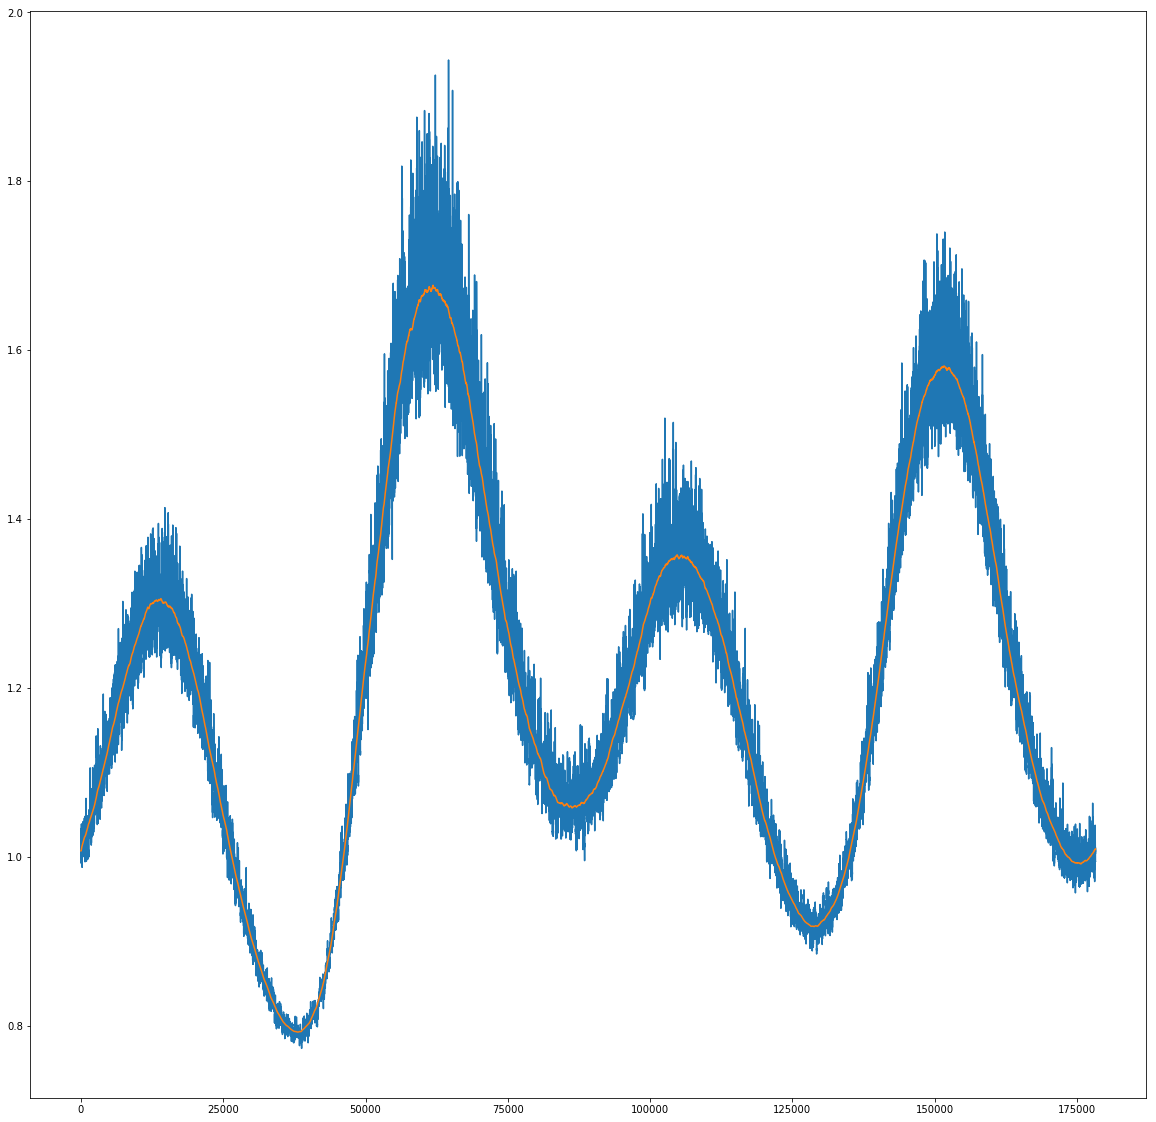

In [15]:
plt.figure(figsize=(20,20))
wind = int(l/2)
plt.plot(Depth[wind:-wind])
plt.plot(Smooth_Depth)
plt.scatter(np.argmax(Smooth_Depth),np.max(Smooth_Depth), s=10)

In [16]:
print('Maximum Depth of ', np.max(Smooth_Depth),'m at ',Time[np.argmax(Smooth_Depth)])
print('Start time must be after ',Time[0], ' + ', str(wind/60), 'minutes')

Maximum Depth of  1.67700906914 m at  2018-05-23T02:28:40.000000000
Start time must be after  2018-05-22T09:17:41.000000000  +  25.0 minutes


# Tide sinchronisation and correction

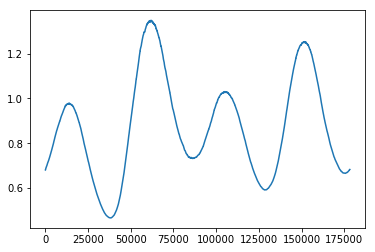

In [17]:
MaxTide = 1.35
TideCollection = Smooth_Depth - (np.max(Smooth_Depth) - MaxTide)
plt.plot(TideCollection)

In [18]:
assert len(TideCollection) == len(Time_reduced)
TideFrame = pd.DataFrame(data=Time_reduced, columns=np.array(['Time']))
TideFrame['Tide'] = TideCollection

# Opening in-situ datafile


In [19]:
FolderPath = '../../Terrain/MesuresBathy/'
FileName = ['Poe_11_11_21__05_22_2018.txt', 'Poe_13_26_36__05_23_2018.txt']
Date = ['2018-05-22', '2018-05-23']
j = 0
FilePathSur = FolderPath + FileName[j]

assert os.path.exists(FilePathSur)

def UTC0ToDateGMT11(TimeStr, Date):
    UncheckedDate = Date + 'T' + str(int(TimeStr[:2])+11)+TimeStr[2:][:6]
    if UncheckedDate[-2:] == '60':
        UncheckedDate = UncheckedDate[:-5] + str(int(UncheckedDate[-5:-3])+1)+':00'
    return UncheckedDate

# Creating and writing a corrected and workable Depth file

In [20]:
FileWorkableSur = '../../Terrain/MesuresBathy/Poe_22and23_05_2018.txt'
Fichier_Travaillable = open(FileWorkableSur, "w")
firstwritted = False
Recorded_time = []

for fname, Ddate in zip(FileName, Date):
    FilePathSur = FolderPath + fname
    
    with open(FilePathSur, "r") as Fichier_Hypack:
        lines = Fichier_Hypack.readlines()
        for lineNumber, line in enumerate(lines):
            if lineNumber == 0 :
                if firstwritted == False:
                    Fichier_Travaillable.write('DateTimeUTC11, Lon, Lat, Depth\n')
                    firstwritted = True
                elif firstwritted:
                    continue
            else:
                InSitu_Date = UTC0ToDateGMT11(line.split(',')[0],Ddate)
                Recorded_time.append(TideFrame['Time']==InSitu_Date)

                Tide = TideFrame[TideFrame['Time']==InSitu_Date]['Tide'].values[0]
                WaterLevel = np.float(line.split(',')[3].split('\n')[0])
                Depth = WaterLevel - Tide

                entree = InSitu_Date + ',' + line.split(',')[1] + ',' + line.split(',')[2] + ',' + '{0:.2f}'.format(Depth) + '\n' 
                Fichier_Travaillable.write(entree)
              
            
Fichier_Travaillable.close()

# Visual checking of the recording time

In [21]:
Time_Index = np.sum(np.stack(Recorded_time,axis=1), axis=1)
plottedDates = [pd.to_datetime(d) for d in Time_reduced]

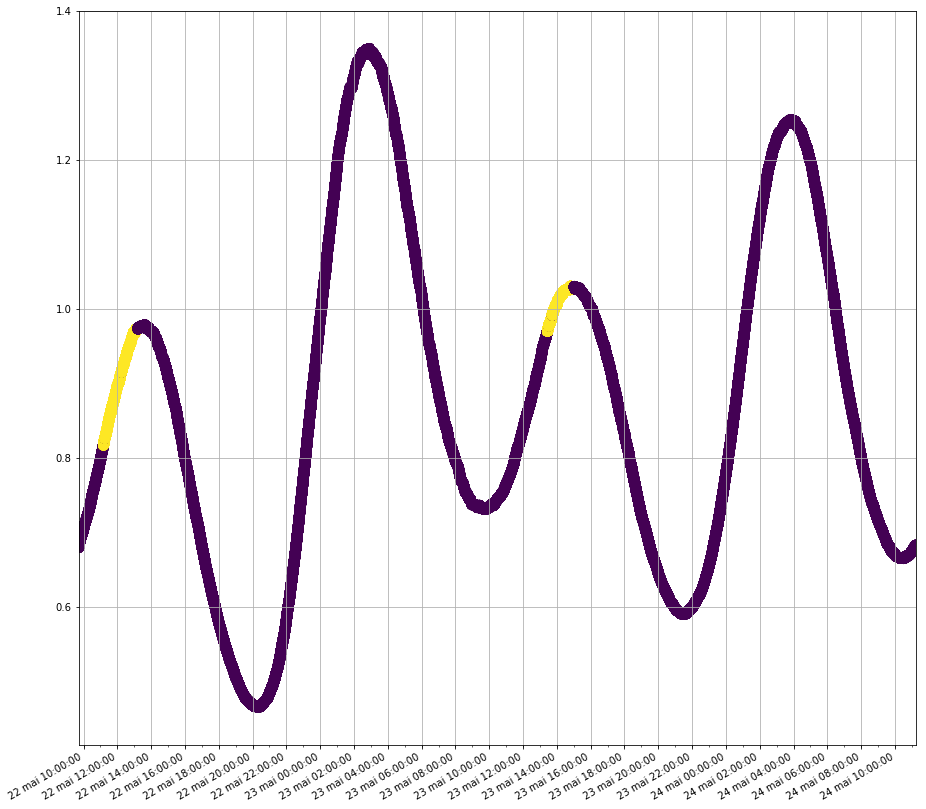

In [22]:

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(plottedDates, TideCollection, s =100, c=Time_Index>0)
ax.set_xlim(plottedDates[0], plottedDates[-1])


ax.xaxis.set_major_locator(HourLocator(np.arange(0, 25, 2)))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d mai %H:%M:%S'))
ax.grid()

ax.fmt_xdata = DateFormatter('%Y-%m-%d %H:%M:%S')
fig.autofmt_xdate()

plt.show()